# Music instrument detection

## Dependencies

In [33]:
pip install google_images_download tensorflow pydot graphviz pydotplus opencv-contrib-python sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=875a6dc74a30ee24ba9abc19b3a3323dad3b2df8c6c0863167b7c5c30e358318
  Stored in directory: /home/jovyan/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install graphviz

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    cairo-1.16.0               |    hfb77d84_1002         1.5 MB  conda-forge
    certifi-2019.9.11          |           py37_0         147 KB  conda-forge
    expat-2.2.5                |    he1b5a44_1004         191 KB  conda-forge
    fontconfig-2.13.1          |    h86ecdb6_1001         340 KB  conda-forge
    fribidi-1.0.5              |    h516909a_1002         112 KB  conda-forge
    gettext-0.19.8.1           |    hc5be6a0_1002         3.6 MB  conda-forge
    glib-2.58.

In [1]:
%load_ext tensorboard

## Download images

In [10]:
from google_images_download import google_images_download

In [13]:
response = google_images_download.googleimagesdownload()
pianos = response.download({"keywords":"piano","limit":100,"print_urls":False})
drums = response.download({"keywords":"drums","limit":100,"print_urls":False})


Item no.: 1 --> Item name = piano
Evaluating...
Starting Download...
Completed Image ====> 1.CVP809GPE-large.jpg
Completed Image ====> 2.Kawai-RX-1-Grand-Piano.jpg
Completed Image ====> 3.12236247_800.jpg
Completed Image ====> 4.Kawai-Novus-NV10.jpg
Completed Image ====> 5.bosendorfer_model_280_vc_1_20150802_11006819671.jpg
Completed Image ====> 6.ROLAND+GOPIANO-2.JPG
Completed Image ====> 7.10721_1.jpg
Completed Image ====> 8.HE1656981_182037-HOP-MUS-P01.jpg
Completed Image ====> 9.10395977_800.jpg
Completed Image ====> 10.718-sZJ-zVL._SY355_.jpg
Completed Image ====> 11.900x520_piano-min.jpg
Completed Image ====> 12.3138.jpg
Completed Image ====> 13.bosendorfer_standard_290_imperial_1_20100724_17015890701.jpg
Completed Image ====> 14.KawaiGM2_2.jpg
Completed Image ====> 15.607-Queen-Anne-Classic-Mahogany-1.jpg
Invalid or missing image format. Skipping...
Completed Image ====> 16.71dJirSSewL._SL1500_.jpg
Completed Image ====> 17.yamaha_baby_grand_piano_for_rent2-e1463093616843-1000x1

Completed Image ====> 37.british-drum-co-british-drum-co-lounge-20-wiltshire-white.jpg
Completed Image ====> 38.trick-drums-vmt-series-drumset.jpg
Completed Image ====> 39.Products15508-640x640--171242163.jpg
Completed Image ====> 40.quobsrcp3h8nplwbkkti.jpg
Completed Image ====> 41.td-25kvx_front_gal.jpg
Completed Image ====> 42.wzc28kdvdmzxams1p0dp.jpg
Completed Image ====> 43.TXJ3BK.jpg
Completed Image ====> 44.resizedcrop-4f3436d1854506feed4434d6b352629c-840x480.jpg
Completed Image ====> 45.Lyu2vCqZQpBKJQyHV3XNGW-1200-80.jpg
Completed Image ====> 46.batterie-simone-erable-20x12x14.jpg
Completed Image ====> 47.drum_sets_1200x480_cc5f267f6942beb70f883505e475c9fc.jpg
Completed Image ====> 48.BritishDrumCo_Legend_Series_CARABYSLATE_4Piece_01.png
Completed Image ====> 49.Banging-Drums-Thumbnail-450x450.jpg
Completed Image ====> 50.1508329294_1366249.jpg
Completed Image ====> 51.c_c-aged-copper-over-steel-snare-drum-14x5-1.jpg
Completed Image ====> 52.14008547_800.jpg
Completed Image ===

## Resize images

In [12]:
import cv2
import os

In [99]:
def resize(inputfolder, outputfolder, labelfolder):
    os.makedirs(os.path.join(outputfolder, "train", labelfolder), exist_ok=True)
    os.makedirs(os.path.join(outputfolder, "test", labelfolder), exist_ok=True)
    index = 0
    for file in os.listdir(inputfolder):
        if file.lower().endswith(".jpg") or file.lower().endswith(".png") or file.lower().endswith(".jpeg"):
            path = os.path.join(inputfolder, file)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            dim = (150, 150)
            resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            
            outputpath = ""
            if index % 2 == 0:
                outputpath = os.path.join(outputfolder, "train", labelfolder)
            else:
                outputpath = os.path.join(outputfolder, "test", labelfolder)
            cv2.imwrite(os.path.join(outputpath, file[:-3] + 'jpg'), resized)
            index += 1

resize("downloads/piano", "images", "piano")
resize("downloads/drums", "images", "drums")    

## Setup data

In [10]:
import tensorflow as tf
import numpy as np
import pathlib
from matplotlib import pyplot as plt
import glob

In [13]:
train_image_size = len(glob.glob('images/train/*/*.jpg'))
test_image_size = len(glob.glob('images/test/*/*.jpg'))

variations = 100

total_train_images = train_image_size * variations

X_train = np.zeros((total_train_images, 150, 150, 1))
y_train = np.zeros((total_train_images))

X_test = np.zeros((test_image_size, 150, 150, 1))
y_test = np.zeros((test_image_size))

trainindex = 0
testindex = 0

def loadimages(folder, labelfolder, label):
    global X_train
    global y_train
    global X_test
    global y_test
    global trainindex
    global testindex
    global variations
    
    f = os.path.join(folder, "test", labelfolder)
    for file in os.listdir(f):
        if file.lower().endswith(".jpg"):
            path = os.path.join(f, file)
            im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            
            X_test[testindex] = im.reshape((150, 150, 1))
            y_test[testindex] = label
            testindex += 1
    
    f = os.path.join(folder, "test", labelfolder)
    for file in os.listdir(f):
        if file.lower().endswith(".jpg"):
            path = os.path.join(f, file)
            im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            
            data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                    rotation_range=90,
                    width_shift_range=0.3,
                    height_shift_range=0.3,
                    brightness_range=(0.1, 0.9),
                    zoom_range=[0.5, 1.5],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest'
                )
            image_iterator = data_generator.flow(im.reshape((1, 150, 150, 1)))
            for j in range(0, variations):
                X_train[trainindex] = image_iterator.next().reshape((150, 150, 1))
                y_train[trainindex] = label
                trainindex += 1
                    

loadimages("images", "piano", 0)
loadimages("images", "drums", 1)

X_train = X_train.reshape((-1, 150, 150, 1))
X_test = X_test.reshape((-1, 150, 150, 1))

X_train /= 255
X_test /= 255

Y_train = tf.keras.utils.to_categorical(y_train, 2)
Y_test = tf.keras.utils.to_categorical(y_test, 2)

In [121]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(9500, 150, 150, 1)
(9500, 2)
(94, 150, 150, 1)
(94, 2)


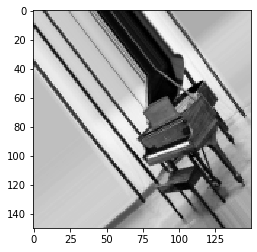

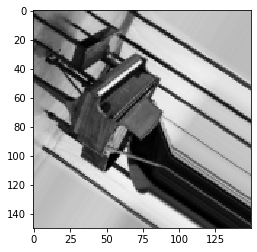

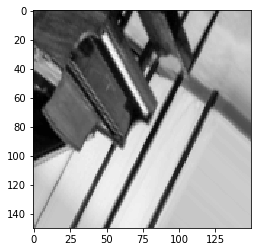

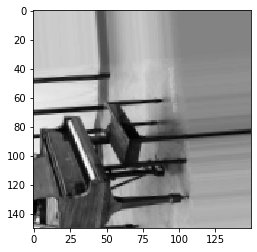

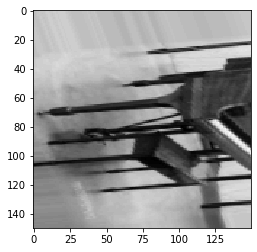

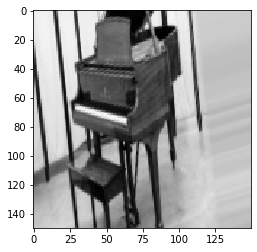

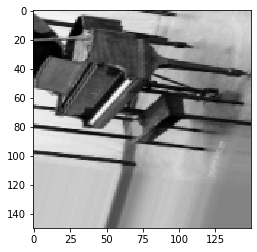

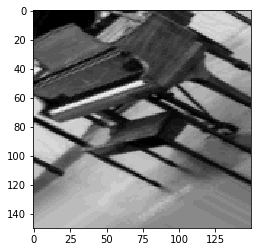

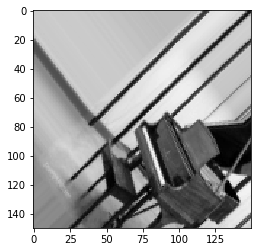

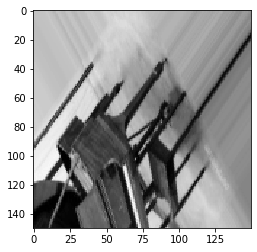

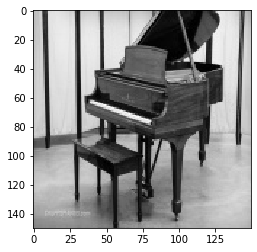

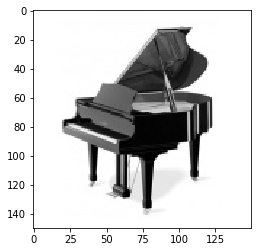

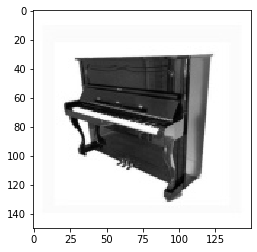

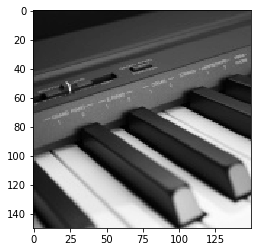

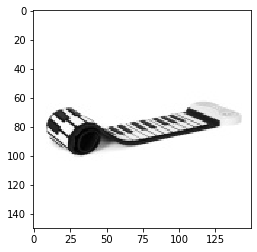

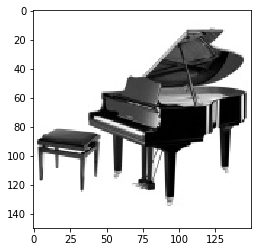

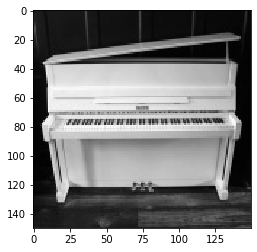

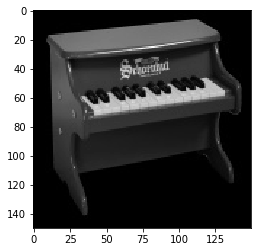

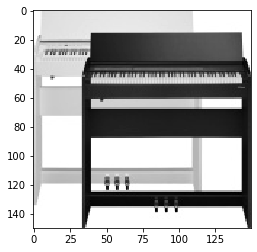

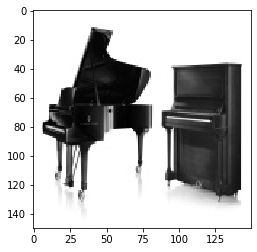

In [14]:
for i in range(0, 10):
    plt.figure()
    plt.imshow(X_train[i].reshape(150, 150), cmap='gray')

for i in range(0, 10):
    plt.figure()
    plt.imshow(X_test[i].reshape(150, 150), cmap='gray')

## Build and train model

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 140, 140, 32)      3904      
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 136, 136, 32)      25632     
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 134, 134, 32)      9248      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 29, 29, 32)        25632     
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 13, 13, 32)      

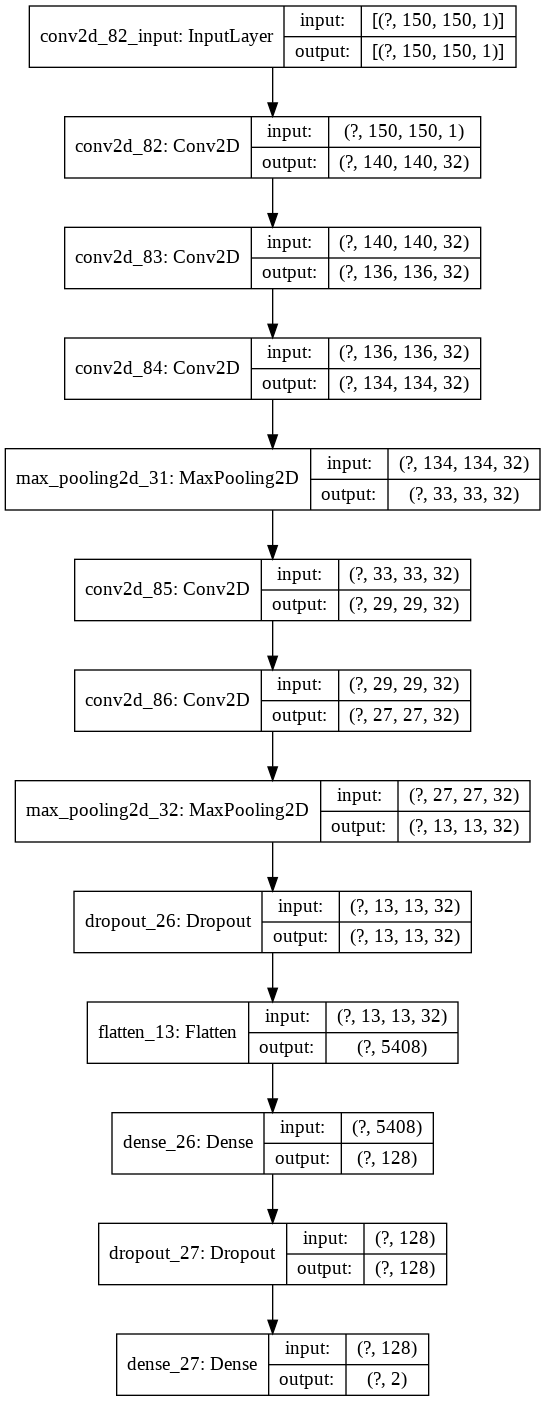

In [123]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Convolution2D(filters=32, kernel_size=(11, 11), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.Convolution2D(filters=32, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.Convolution2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(4,4)),
    tf.keras.layers.Convolution2D(filters=32, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.Convolution2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [124]:
history = model.fit(
    X_train, Y_train, batch_size=32, epochs=5, verbose=1,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./instrument-detector-logs', update_freq='batch')]
)

Train on 9500 samples
Epoch 1/5
9500/9500 [==============================] - 553s 58ms/sample - loss: 0.5517 - accuracy: 0.7297
Epoch 2/5
9500/9500 [==============================] - 510s 54ms/sample - loss: 0.4833 - accuracy: 0.7798
Epoch 3/5
9500/9500 [==============================] - 509s 54ms/sample - loss: 0.4374 - accuracy: 0.8035
Epoch 4/5
9500/9500 [==============================] - 506s 53ms/sample - loss: 0.4605 - accuracy: 0.7911
Epoch 5/5
9500/9500 [==============================] - 504s 53ms/sample - loss: 0.3886 - accuracy: 0.8299


## Evaluate

In [125]:
model.evaluate(X_test, Y_test, verbose=0)

[0.41051877432681144, 0.82978725]

In [4]:
%tensorboard --logdir "instrument-detector-logs" --host 0.0.0.0

## Save / Restore

In [133]:
model.save('instrument_classifier.h5')

In [7]:
model = tf.keras.models.load_model('instrument_classifier.h5')

## Confusion Matrix, ROC, AUC

In [ ]:
def get_class(idx):
    if (idx == 0):
        return "piano"
    else:
        return "drums"

In [34]:
confusion_matrix = np.zeros((2, 2))

predictions = model.predict(X_test)

for i in range(0, predictions.shape[0]):
    img = X_test[i]
    prediction = np.argmax(predictions[i])
    actual = int(y_test[i])
    confusion_matrix[actual][prediction] += 1

print(get_class(0))
print(get_class(1))
print(confusion_matrix)

piano
drums
[[43.  2.]
 [14. 35.]]


0.8349206349206351


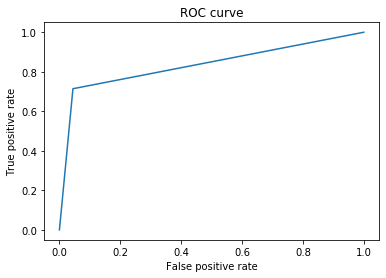

In [47]:
import sklearn

y_pred = np.argmax(model.predict(X_test), 1)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)
auc = sklearn.metrics.auc(fpr, tpr)

print(auc)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## Prediction

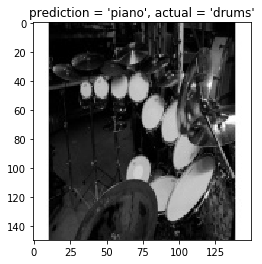

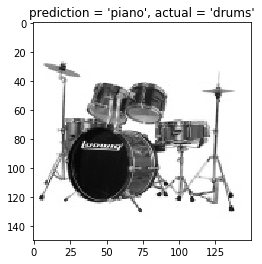

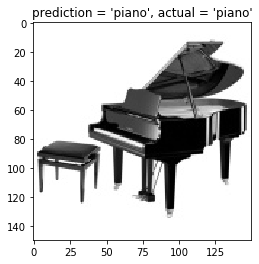

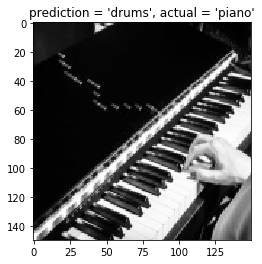

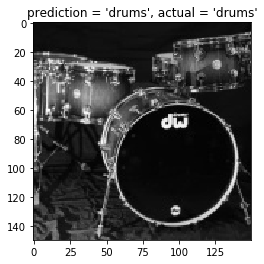

In [17]:
for i in np.random.choice(X_test.shape[0], size=5):
    img = X_test[i]
    prediction = model.predict(img.reshape(1, 150, 150, 1))
    
    plt.figure()
    plt.imshow(img.reshape(150, 150), cmap='gray')
    plt.title("prediction = '%s', actual = '%s'" % (get_class(np.argmax(prediction)), get_class(y_test[i])))